# Visualizing Dota 2 Teams Performance

In [1]:
import requests
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

The data had been fetched from OpenDota API and preprocessed to get a dataframe consisting of the results of the active teams for patch 7.26c.

In [2]:
pro_results = pd.read_pickle('data\pro_teams_results.pkl')
pro_results.describe()

,dire_losses,dire_win,duration,gold_advantage,kills,matches,radiant_losses,radiant_wins,team,unique_heroes_banned_against,unique_heroes_played,xp_advantage
count,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,5.230000e+02,523.000000,523.000000,523.000000
mean,4.256214,4.216061,1888.094615,-7407.889566,-8.205521,16.944551,4.216061,4.256214,6.965476e+06,28.483748,31.325048,-7613.957033
std,6.475073,7.373010,451.190497,13139.121196,15.069084,25.714070,6.588999,7.378864,1.815935e+06,24.721615,29.447425,14604.859362
min,0.000000,0.000000,540.000000,-42359.000000,-65.000000,1.000000,0.000000,0.000000,4.000000e+00,0.000000,0.000000,-49354.666667
25%,1.000000,0.000000,1572.395782,-18588.000000,-19.250000,1.000000,0.000000,0.000000,7.099012e+06,6.000000,5.000000,-18754.906250
50%,1.000000,1.000000,1949.166667,-4133.090909,-5.000000,5.000000,1.000000,1.000000,7.731375e+06,22.000000,21.000000,-5597.368421
75%,5.000000,5.000000,2170.572239,2147.500000,2.309524,19.000000,5.000000,5.000000,7.957740e+06,44.500000,51.500000,2329.397993
max,35.000000,42.000000,3566.000000,30995.000000,40.000000,144.000000,46.000000,45.000000,8.041222e+06,102.000000,103.000000,46375.000000


In [4]:
pro_results = pro_results[pro_results['matches']>4]
len(pro_results)

274

Team names and over all results were not included in the preprocessed data so let's get these data from OpenDota API and merge it to our current dataframe.

In [4]:
teams = pd.DataFrame([])
for team in pro_results['team']:
    r = requests.get('https://api.opendota.com/api/teams/{}'.format(int(team)))
    print(r)
    teams = teams.append(pd.read_json(r.text, lines=True, orient='columns'))
    print('Getting data for team {}.'.format(team), flush=True)
    time.sleep(1)
results = pro_results.merge(teams, how='left', left_on='team', right_on='team_id')
results

<Response [200]>
Getting data for team 6953913.0.
<Response [200]>
Getting data for team 6685591.0.
<Response [200]>
Getting data for team 2163.0.
<Response [200]>
Getting data for team 2586976.0.
<Response [200]>
Getting data for team 7684041.0.
<Response [200]>
Getting data for team 7554697.0.
<Response [200]>
Getting data for team 1838315.0.
<Response [200]>
Getting data for team 7820540.0.
<Response [200]>
Getting data for team 111474.0.
<Response [200]>
Getting data for team 7819701.0.
<Response [200]>
Getting data for team 7930695.0.
<Response [200]>
Getting data for team 6209143.0.
<Response [200]>
Getting data for team 6214973.0.
<Response [200]>
Getting data for team 7119388.0.
<Response [200]>
Getting data for team 1883502.0.
<Response [200]>
Getting data for team 36.0.
<Response [200]>
Getting data for team 726228.0.
<Response [200]>
Getting data for team 7407260.0.
<Response [200]>
Getting data for team 4.0.
<Response [200]>
Getting data for team 1375614.0.
<Response [200]>

,dire_losses,dire_win,duration,gold_advantage,kills,matches,radiant_losses,radiant_wins,team,unique_heroes_banned_against,unique_heroes_played,xp_advantage,team_id,rating,wins,losses,last_match_time,name,tag,logo_url
0,11.0,9.0,1979.500000,3708.707317,2.000000,82.0,21.0,41.0,6953913.0,64.0,83.0,5052.487805,6953913,1333.300,153,121,2020-07-05 17:08:51,FlyToMoon,FTM,https://steamusercontent-a.akamaihd.net/ugc/91...
1,12.0,14.0,2202.887640,1470.685393,3.202247,89.0,26.0,37.0,6685591.0,66.0,88.0,5037.449438,6685591,1303.130,204,127,2020-06-27 13:03:02,ViKin.gg,Vikin.gg,https://steamusercontent-a.akamaihd.net/ugc/77...
2,17.0,25.0,2264.843373,2333.795181,6.216867,83.0,18.0,23.0,2163.0,74.0,92.0,8657.590361,2163,1365.060,938,609,2020-06-28 14:07:56,Team Liquid,Liquid,https://steamcdn-a.akamaihd.net/apps/dota2/ima...
3,21.0,18.0,1970.220588,-1795.161765,-3.941176,68.0,14.0,15.0,2586976.0,74.0,88.0,-3224.500000,2586976,1283.560,604,352,2020-06-25 18:51:46,OG,OG,https://steamcdn-a.akamaihd.net/apps/dota2/ima...
4,15.0,4.0,2199.514286,-8939.428571,-8.514286,35.0,12.0,4.0,7684041.0,55.0,72.0,-11058.485714,7684041,1002.320,30,76,2020-06-24 12:57:55,B8,B8,https://steamusercontent-a.akamaihd.net/ugc/77...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,3.0,2.0,1601.400000,1894.400000,0.600000,5.0,0.0,0.0,7468974.0,20.0,16.0,4146.600000,7468974,986.513,17,17,2020-07-16 18:25:09,SandBlood,Sb,https://steamusercontent-a.akamaihd.net/ugc/10...
270,3.0,2.0,1499.000000,-441.200000,-4.200000,5.0,0.0,0.0,7732883.0,20.0,23.0,-4783.800000,7732883,986.660,2,3,2020-05-17 07:53:13,GamersVille,GV,https://steamusercontent-a.akamaihd.net/ugc/10...
271,4.0,3.0,1895.285714,-1147.857143,5.714286,7.0,0.0,0.0,8021491.0,22.0,22.0,684.285714,8021491,989.354,3,4,2020-06-12 07:00:32,EZ,EZ,https://steamusercontent-a.akamaihd.net/ugc/10...
272,2.0,3.0,2237.000000,7044.000000,5.000000,5.0,0.0,0.0,7961113.0,18.0,19.0,6917.400000,7961113,1017.250,3,2,2020-06-06 08:46:24,Stonetree Gaming,STG^,https://steamusercontent-a.akamaihd.net/ugc/10...


In [2]:
# results.to_pickle('data\pro_results_expanded.pkl')
results = pd.read_pickle('data\pro_results_expanded.pkl')

In [7]:
results['patch_wins'] = results['radiant_wins'] + results['dire_win']
results['patch_win_rate'] = results['patch_wins']/results['matches']
results.nlargest(n=10, columns='patch_wins')

,dire_losses,dire_win,duration,gold_advantage,kills,matches,radiant_losses,radiant_wins,team,unique_heroes_banned_against,unique_heroes_played,xp_advantage,team_id,wins,losses,name,patch_wins,patch_win_rate,win_rate
45,35.0,40.0,2239.993056,4109.236111,6.659722,144.0,24.0,45.0,6187657.0,75.0,93.0,6147.986111,6187657,456,321,Neon Esports,85.0,0.590278,0.586873
6,7.0,40.0,2044.564103,13078.910256,12.333333,78.0,4.0,27.0,1838315.0,71.0,95.0,16073.782051,1838315,842,388,Team Secret,67.0,0.858974,0.684553
97,21.0,29.0,2134.962264,2186.179245,2.132075,106.0,27.0,29.0,7484403.0,76.0,94.0,3035.792453,7484403,120,121,Ocean,58.0,0.547170,0.497925
43,18.0,30.0,2245.677778,3580.300000,4.255556,90.0,17.0,25.0,7424172.0,68.0,91.0,3573.855556,7424172,89,74,T1,55.0,0.611111,0.546012
64,32.0,42.0,2089.042105,2955.273684,1.526316,95.0,8.0,13.0,6409189.0,74.0,75.0,965.305263,6409189,167,132,Team Empire Hope,55.0,0.578947,0.558528
239,23.0,28.0,1443.391753,1035.360825,0.659794,97.0,21.0,25.0,7852100.0,93.0,92.0,1560.907216,7852100,82,74,TEAM LIGHTNING,53.0,0.546392,0.525641
20,12.0,27.0,2058.670886,6133.772152,5.822785,79.0,15.0,25.0,15.0,70.0,90.0,7345.151899,15,1212,787,PSG.LGD,52.0,0.658228,0.606303
42,11.0,34.0,2083.681159,8271.594203,5.797101,69.0,6.0,18.0,350190.0,69.0,81.0,8713.434783,350190,1003,708,Fnatic,52.0,0.753623,0.586207
1,12.0,14.0,2202.887640,1470.685393,3.202247,89.0,26.0,37.0,6685591.0,66.0,88.0,5037.449438,6685591,204,127,ViKin.gg,51.0,0.573034,0.616314
47,16.0,28.0,2092.986842,6293.171053,4.697368,76.0,9.0,23.0,3586078.0,69.0,82.0,8180.486842,3586078,285,228,Geek Fam,51.0,0.671053,0.555556


In [7]:
results = results.drop(columns=['last_match_time', 'tag', 'logo_url', 'rating'])
results.isna().sum()

dire_losses                     0
dire_win                        0
duration                        0
gold_advantage                  0
kills                           0
matches                         0
radiant_losses                  0
radiant_wins                    0
team                            0
unique_heroes_banned_against    0
unique_heroes_played            0
xp_advantage                    0
team_id                         0
wins                            0
losses                          0
name                            0
patch_wins                      0
patch_win_rate                  0
dtype: int64

In [10]:
results.nlargest(n=10, columns='wins')

,dire_losses,dire_win,duration,gold_advantage,kills,matches,radiant_losses,radiant_wins,team,unique_heroes_banned_against,unique_heroes_played,xp_advantage,team_id,wins,losses,name,patch_wins,patch_win_rate,win_rate
14,17.0,24.0,2057.012500,2863.125000,1.850000,80.0,17.0,22.0,1883502.0,63.0,89.0,1125.525000,1883502,1244,943,Virtus.pro,46.0,0.575000,0.568816
20,12.0,27.0,2058.670886,6133.772152,5.822785,79.0,15.0,25.0,15.0,70.0,90.0,7345.151899,15,1212,787,PSG.LGD,52.0,0.658228,0.606303
16,6.0,10.0,2055.969231,2810.323077,3.169231,65.0,20.0,29.0,726228.0,64.0,76.0,3449.646154,726228,1150,758,Vici Gaming,39.0,0.600000,0.602725
72,10.0,11.0,2287.948718,3800.769231,3.230769,39.0,8.0,10.0,39.0,50.0,67.0,4040.641026,39,1119,679,Evil Geniuses,21.0,0.538462,0.622358
22,27.0,29.0,2248.788889,2296.755556,0.777778,90.0,13.0,21.0,5.0,73.0,88.0,4943.188889,5,1111,758,INVICTUS GAMING,50.0,0.555556,0.594436
8,17.0,17.0,2170.104478,-1841.955224,-2.164179,67.0,16.0,17.0,111474.0,65.0,89.0,-2535.388060,111474,1040,783,Alliance,34.0,0.507463,0.570488
42,11.0,34.0,2083.681159,8271.594203,5.797101,69.0,6.0,18.0,350190.0,69.0,81.0,8713.434783,350190,1003,708,Fnatic,52.0,0.753623,0.586207
2,17.0,25.0,2264.843373,2333.795181,6.216867,83.0,18.0,23.0,2163.0,74.0,92.0,8657.590361,2163,938,609,Team Liquid,48.0,0.578313,0.606335
6,7.0,40.0,2044.564103,13078.910256,12.333333,78.0,4.0,27.0,1838315.0,71.0,95.0,16073.782051,1838315,842,388,Team Secret,67.0,0.858974,0.684553
18,9.0,15.0,2251.571429,955.125000,-0.982143,56.0,17.0,15.0,4.0,65.0,85.0,-377.321429,4,715,573,EHOME,30.0,0.535714,0.555124


In [38]:
results['win_rate'] = results['wins']/(results['wins'] + results['losses'])
results.nlargest(n=10, columns='win_rate')

,dire_losses,dire_win,duration,gold_advantage,kills,matches,radiant_losses,radiant_wins,team,unique_heroes_banned_against,unique_heroes_played,xp_advantage,team_id,wins,losses,name,patch_wins,patch_win_rate,win_rate
65,4.0,11.0,2265.282051,11490.769231,12.666667,39.0,6.0,18.0,7390454.0,52.0,64.0,16346.589744,7390454,63,27,Quincy Crew,29.0,0.743590,0.700000
9,6.0,11.0,2107.716981,5035.660377,4.132075,53.0,15.0,21.0,7819701.0,57.0,66.0,8510.433962,7819701,64,29,VP.Prodigy,32.0,0.603774,0.688172
6,7.0,40.0,2044.564103,13078.910256,12.333333,78.0,4.0,27.0,1838315.0,71.0,95.0,16073.782051,1838315,842,388,Team Secret,67.0,0.858974,0.684553
71,10.0,19.0,2047.754098,2578.901639,5.508197,61.0,15.0,17.0,6382242.0,63.0,83.0,3645.163934,6382242,145,72,Thunder Predator,36.0,0.590164,0.668203
3,21.0,18.0,1970.220588,-1795.161765,-3.941176,68.0,14.0,15.0,2586976.0,74.0,88.0,-3224.500000,2586976,604,352,OG,33.0,0.485294,0.631799
99,3.0,5.0,2450.384615,3168.358974,5.205128,39.0,15.0,16.0,7204148.0,53.0,70.0,6442.128205,7204148,33,20,Flash Point Gaming,21.0,0.538462,0.622642
72,10.0,11.0,2287.948718,3800.769231,3.230769,39.0,8.0,10.0,39.0,50.0,67.0,4040.641026,39,1119,679,Evil Geniuses,21.0,0.538462,0.622358
1,12.0,14.0,2202.887640,1470.685393,3.202247,89.0,26.0,37.0,6685591.0,66.0,88.0,5037.449438,6685591,204,127,ViKin.gg,51.0,0.573034,0.616314
67,13.0,10.0,2096.736842,-711.964912,-2.105263,57.0,13.0,21.0,7819028.0,62.0,79.0,-237.000000,7819028,61,38,4 Zoomers,31.0,0.543860,0.616162
2,17.0,25.0,2264.843373,2333.795181,6.216867,83.0,18.0,23.0,2163.0,74.0,92.0,8657.590361,2163,938,609,Team Liquid,48.0,0.578313,0.606335


In [39]:
results.nlargest(n=10, columns='patch_wins')

,dire_losses,dire_win,duration,gold_advantage,kills,matches,radiant_losses,radiant_wins,team,unique_heroes_banned_against,unique_heroes_played,xp_advantage,team_id,wins,losses,name,patch_wins,patch_win_rate,win_rate
45,35.0,40.0,2239.993056,4109.236111,6.659722,144.0,24.0,45.0,6187657.0,75.0,93.0,6147.986111,6187657,456,321,Neon Esports,85.0,0.590278,0.586873
6,7.0,40.0,2044.564103,13078.910256,12.333333,78.0,4.0,27.0,1838315.0,71.0,95.0,16073.782051,1838315,842,388,Team Secret,67.0,0.858974,0.684553
97,21.0,29.0,2134.962264,2186.179245,2.132075,106.0,27.0,29.0,7484403.0,76.0,94.0,3035.792453,7484403,120,121,Ocean,58.0,0.547170,0.497925
43,18.0,30.0,2245.677778,3580.300000,4.255556,90.0,17.0,25.0,7424172.0,68.0,91.0,3573.855556,7424172,89,74,T1,55.0,0.611111,0.546012
64,32.0,42.0,2089.042105,2955.273684,1.526316,95.0,8.0,13.0,6409189.0,74.0,75.0,965.305263,6409189,167,132,Team Empire Hope,55.0,0.578947,0.558528
239,23.0,28.0,1443.391753,1035.360825,0.659794,97.0,21.0,25.0,7852100.0,93.0,92.0,1560.907216,7852100,82,74,TEAM LIGHTNING,53.0,0.546392,0.525641
20,12.0,27.0,2058.670886,6133.772152,5.822785,79.0,15.0,25.0,15.0,70.0,90.0,7345.151899,15,1212,787,PSG.LGD,52.0,0.658228,0.606303
42,11.0,34.0,2083.681159,8271.594203,5.797101,69.0,6.0,18.0,350190.0,69.0,81.0,8713.434783,350190,1003,708,Fnatic,52.0,0.753623,0.586207
1,12.0,14.0,2202.887640,1470.685393,3.202247,89.0,26.0,37.0,6685591.0,66.0,88.0,5037.449438,6685591,204,127,ViKin.gg,51.0,0.573034,0.616314
47,16.0,28.0,2092.986842,6293.171053,4.697368,76.0,9.0,23.0,3586078.0,69.0,82.0,8180.486842,3586078,285,228,Geek Fam,51.0,0.671053,0.555556


In [11]:
results = results[results['matches'] > 30]
results.nlargest(n=10, columns='patch_win_rate')

,dire_losses,dire_win,duration,gold_advantage,kills,matches,radiant_losses,radiant_wins,team,unique_heroes_banned_against,unique_heroes_played,xp_advantage,team_id,wins,losses,name,patch_wins,patch_win_rate,win_rate
6,7.0,40.0,2044.564103,13078.910256,12.333333,78.0,4.0,27.0,1838315.0,71.0,95.0,16073.782051,1838315,842,388,Team Secret,67.0,0.858974,0.684553
42,11.0,34.0,2083.681159,8271.594203,5.797101,69.0,6.0,18.0,350190.0,69.0,81.0,8713.434783,350190,1003,708,Fnatic,52.0,0.753623,0.586207
65,4.0,11.0,2265.282051,11490.769231,12.666667,39.0,6.0,18.0,7390454.0,52.0,64.0,16346.589744,7390454,63,27,Quincy Crew,29.0,0.743590,0.700000
29,4.0,5.0,1982.032258,3952.709677,6.419355,31.0,6.0,16.0,7653600.0,54.0,68.0,6506.451613,7653600,65,68,Aggressive Mode,21.0,0.677419,0.488722
47,16.0,28.0,2092.986842,6293.171053,4.697368,76.0,9.0,23.0,3586078.0,69.0,82.0,8180.486842,3586078,285,228,Geek Fam,51.0,0.671053,0.555556
20,12.0,27.0,2058.670886,6133.772152,5.822785,79.0,15.0,25.0,15.0,70.0,90.0,7345.151899,15,1212,787,PSG.LGD,52.0,0.658228,0.606303
40,9.0,14.0,2136.288136,4097.050847,4.559322,59.0,12.0,24.0,7555613.0,66.0,84.0,3363.457627,7555613,89,74,OG.Seed,38.0,0.644068,0.546012
170,5.0,7.0,2302.657143,6220.514286,3.714286,35.0,8.0,15.0,7358634.0,56.0,63.0,5830.971429,7358634,27,18,S A D B O Y S . A U,22.0,0.628571,0.600000
41,6.0,24.0,2071.770270,3192.067568,3.297297,74.0,22.0,22.0,7732977.0,77.0,85.0,5523.310811,7732977,90,64,BOOM Esports,46.0,0.621622,0.584416
88,8.0,15.0,2105.411765,5623.352941,6.558824,34.0,5.0,6.0,2672298.0,54.0,69.0,6065.970588,2672298,344,306,Infamous Gaming,21.0,0.617647,0.529231


In [4]:
fig = px.scatter(results, x="wins", y="win_rate", hover_name='name')
fig.update_layout(title={'text': 'Number of Wins vs Overall Winrate for All Time',
                         'y':0.95,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'})
fig.update_layout(xaxis_title='Number of Wins',
                  yaxis_title='Win Rate')
fig.show()

In [19]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

patch_win_rate = results['patch_win_rate'].to_numpy()
patch_wins = results['patch_wins'].to_numpy().reshape((-1,1))

poly_reg = PolynomialFeatures(degree=2)
lin_reg2 = LinearRegression()
patch_wins_poly = poly_reg.fit_transform(patch_wins)
# poly_reg.fit(patch_wins_poly, patch_win_rate)
lin_reg2.fit(patch_wins_poly, patch_win_rate)
patch_win_rate_poly = lin_reg2.predict(patch_wins_poly)

lin_reg = LinearRegression()
lin_reg.fit(patch_wins,patch_win_rate)
patch_win_rate_lin = lin_reg.predict(patch_wins)

In [46]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=results['patch_wins'], 
                         y=results['patch_win_rate'], 
                         mode='markers',
                         showlegend=False))
fig.add_trace(go.Scatter(x=results['patch_wins'].sort_values(),
                         y=patch_win_rate_poly,
                         mode='lines',
                         showlegend=False))
fig.update_layout(title={'text': 'Number of Wins vs Overall Winrate for Patch 7.26c',
                         'y':0.95,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'})
fig.update_layout(xaxis_title='Number of Wins',
                  yaxis_title='Win Rate')
fig.show()

In [55]:
radiant_dire = results.nlargest(n=25, columns='patch_win_rate')
radiant_dire = radiant_dire.append(results.nsmallest(n=25, columns='patch_win_rate')).sort_values(by=['patch_win_rate'])

fig = make_subplots(rows=2, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0)
fig.add_trace(go.Bar(x=radiant_dire['name'],
                     y=radiant_dire['radiant_wins']/(radiant_dire['radiant_wins'] + radiant_dire['radiant_losses']),
                     name='Radiant'),
                     row=1, col=1)
fig.add_trace(go.Bar(x=radiant_dire['name'],
                     y=radiant_dire['dire_win']/(radiant_dire['dire_win'] + radiant_dire['dire_losses']),
                     name='Dire'),
                     row=2, col=1)
fig.update_xaxes(title_text='Teams',
                 tickfont_size=8,
                 ticks="",
                 row=2, col=1)
fig.update_xaxes(nticks=len(radiant_dire),
                 row=1, col=1)
fig.update_yaxes(autorange='reversed', row=2, col=1)
fig.update_layout(title=dict(text='Radiant and Dire Win Rate',
                             x=0.5,
                             y=0.95,
                             xanchor='center',
                             yanchor='top'))
fig.show()

In [10]:
import seaborn as sns

,dire_losses,dire_win,duration,gold_advantage,kills,matches,radiant_losses,radiant_wins,team,unique_heroes_banned_against,unique_heroes_played,xp_advantage,team_id,wins,losses,patch_wins,patch_win_rate,win_rate
dire_losses,1.000000,0.570574,-0.205263,-0.337449,-0.372311,0.720729,0.392485,0.146858,0.027907,0.483937,0.573977,-0.373136,0.027907,-0.013519,0.047707,0.451508,-0.332882,-0.202489
dire_win,0.570574,1.000000,-0.066394,0.370230,0.281250,0.705927,0.090306,0.283321,-0.262449,0.398525,0.523043,0.324086,-0.262449,0.332706,0.315789,0.807282,0.434980,0.334090
duration,-0.205263,-0.066394,1.000000,0.117669,0.154106,-0.164116,-0.167500,-0.050781,-0.310825,-0.700409,-0.371608,0.118753,-0.310825,0.202497,0.169489,-0.073273,0.126892,0.214912
gold_advantage,-0.337449,0.370230,0.117669,1.000000,0.839159,0.099431,-0.253336,0.380672,-0.289885,-0.078910,-0.062486,0.941147,-0.289885,0.320862,0.224881,0.468588,0.886649,0.661487
kills,-0.372311,0.281250,0.154106,0.839159,1.000000,0.081626,-0.220097,0.425865,-0.204230,-0.100399,-0.056827,0.869088,-0.204230,0.265491,0.174506,0.440082,0.855449,0.637092
matches,0.720729,0.705927,-0.164116,0.099431,0.081626,1.000000,0.697515,0.718682,-0.076156,0.554183,0.785701,0.093343,-0.076156,0.161842,0.168763,0.889067,0.139180,0.201000
radiant_losses,0.392485,0.090306,-0.167500,-0.253336,-0.220097,0.697515,1.000000,0.568208,0.149313,0.420328,0.613124,-0.218349,0.149313,-0.092063,-0.053227,0.406822,-0.283437,-0.074899
radiant_wins,0.146858,0.283321,-0.050781,0.380672,0.425865,0.718682,0.568208,1.000000,-0.082309,0.291231,0.535118,0.411975,-0.082309,0.175596,0.126913,0.794704,0.441052,0.421006
team,0.027907,-0.262449,-0.310825,-0.289885,-0.204230,-0.076156,0.149313,-0.082309,1.000000,0.168847,-0.070237,-0.260157,1.000000,-0.912679,-0.904252,-0.216764,-0.308441,-0.378284
unique_heroes_banned_against,0.483937,0.398525,-0.700409,-0.078910,-0.100399,0.554183,0.420328,0.291231,0.168847,1.000000,0.718510,-0.082701,0.168847,-0.075737,-0.040538,0.431457,-0.027270,-0.029784


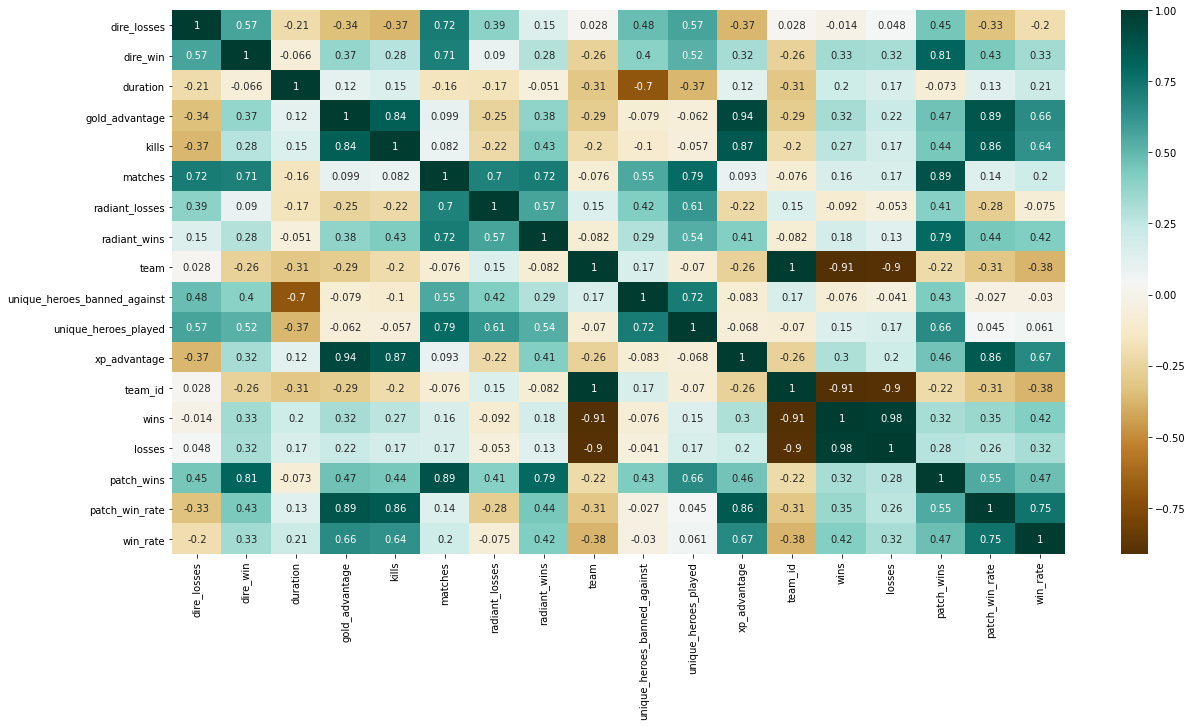

In [25]:
plt.figure(figsize=(20,10))
c= results.corr()
sns.heatmap(c,annot=True, cmap='BrBG')
c

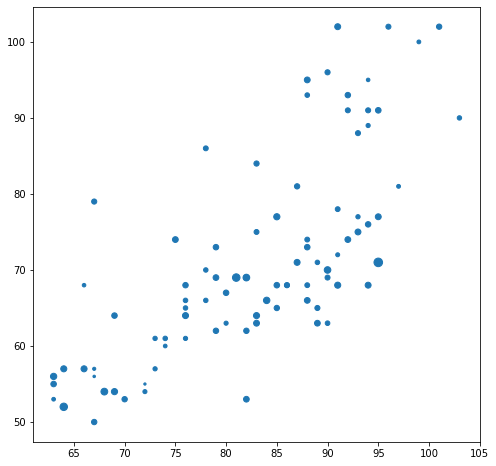

In [24]:
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(x=results['unique_heroes_played'], y=results['unique_heroes_banned_against'], s=(results['patch_win_rate']*10)**2)
# ax.scatter(x=results['patch_win_rate'], y=results['unique_heroes_played'])

In [56]:
results.head(5)

,dire_losses,dire_win,duration,gold_advantage,kills,matches,radiant_losses,radiant_wins,team,unique_heroes_banned_against,unique_heroes_played,xp_advantage,team_id,wins,losses,name,patch_wins,patch_win_rate,win_rate
0,11.0,9.0,1979.500000,3708.707317,2.000000,82.0,21.0,41.0,6953913.0,64.0,83.0,5052.487805,6953913,153,121,FlyToMoon,50.0,0.609756,0.558394
1,12.0,14.0,2202.887640,1470.685393,3.202247,89.0,26.0,37.0,6685591.0,66.0,88.0,5037.449438,6685591,204,127,ViKin.gg,51.0,0.573034,0.616314
2,17.0,25.0,2264.843373,2333.795181,6.216867,83.0,18.0,23.0,2163.0,74.0,92.0,8657.590361,2163,938,609,Team Liquid,48.0,0.578313,0.606335
3,21.0,18.0,1970.220588,-1795.161765,-3.941176,68.0,14.0,15.0,2586976.0,74.0,88.0,-3224.500000,2586976,604,352,OG,33.0,0.485294,0.631799
4,15.0,4.0,2199.514286,-8939.428571,-8.514286,35.0,12.0,4.0,7684041.0,55.0,72.0,-11058.485714,7684041,30,76,B8,8.0,0.228571,0.283019


In [4]:
patch_wins = results['patch_wins'].to_numpy().reshape((-1,1))
patch_wins = np.log(patch_wins)

log_lin_reg = LinearRegression()

log_lin_reg.fit(patch_wins, (results['patch_win_rate']*100).to_numpy())
curve_fit = log_lin_reg.predict(patch_wins)

In [5]:
annotate_teams = results.nlargest(n=3, columns='patch_win_rate', keep='first')
annotate_teams = annotate_teams.append(results.nlargest(n=1, columns='patch_wins', keep='first'))

Text(0, 0.5, 'Win Rate (%)')

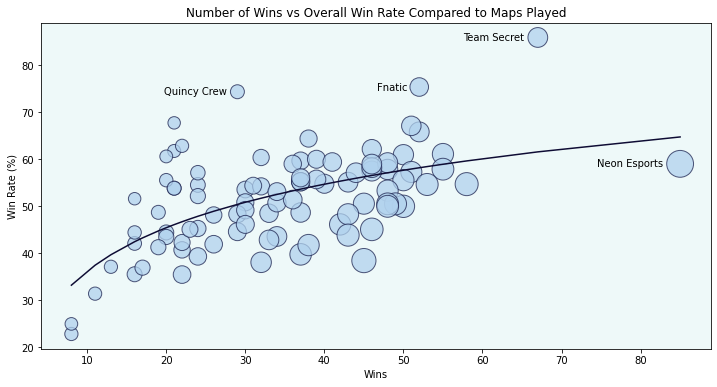

In [6]:
fig, ax = plt.subplots(figsize=(12,6))

plt.title("Number of Wins vs Overall Win Rate Compared to Maps Played")
ax.set_facecolor('#eef9f9')

ax.scatter(x=results['patch_wins'],
           y=results['patch_win_rate']*100,
           s=results['matches']*5,
           c='#b1d2ee',
           edgecolors='#1a214e',
           alpha=0.75)
ax.plot(results['patch_wins'].sort_values(), np.sort(curve_fit),
        c='#0e0c34')

# Can't automate these annotations yet
ax.annotate(annotate_teams['name'].iloc[0],
            xy=(annotate_teams['patch_wins'].iloc[0], annotate_teams['patch_win_rate'].iloc[0]*100),
            xytext=(-75, -3),
            xycoords=('data', 'data'),
            textcoords='offset points',
            fontsize=10)
ax.annotate(annotate_teams['name'].iloc[1],
            xy=(annotate_teams['patch_wins'].iloc[1], annotate_teams['patch_win_rate'].iloc[1]*100),
            xytext=(-42, -3),
            xycoords=('data', 'data'),
            textcoords='offset points',
            fontsize=10)
ax.annotate(annotate_teams['name'].iloc[2],
            xy=(annotate_teams['patch_wins'].iloc[2], annotate_teams['patch_win_rate'].iloc[2]*100),
            xytext=(-73, -3),
            xycoords=('data', 'data'),
            textcoords='offset points',
            fontsize=10)
ax.annotate(annotate_teams['name'].iloc[3],
            xy=(annotate_teams['patch_wins'].iloc[3], annotate_teams['patch_win_rate'].iloc[3]*100),
            xytext=(-83, -3),
            xycoords=('data', 'data'),
            textcoords='offset points',
            fontsize=10)
ax.set_xlabel('Wins')
ax.set_ylabel('Win Rate (%)')


In [7]:
results['dire_win_rate'] = results['dire_win']/(results['dire_win']+results['dire_losses'])
results['radiant_win_rate'] = results['radiant_wins']/(results['radiant_wins']+results['radiant_losses'])

radiant_win_rate = (results['radiant_win_rate']*100).to_numpy().reshape((-1,1))
dire_win_rate = (results['dire_win_rate']*100).to_numpy()

lin_reg = LinearRegression()

lin_reg.fit(radiant_win_rate, dire_win_rate)
curve_fit = lin_reg.predict(np.linspace(0,100).reshape((-1,1)))

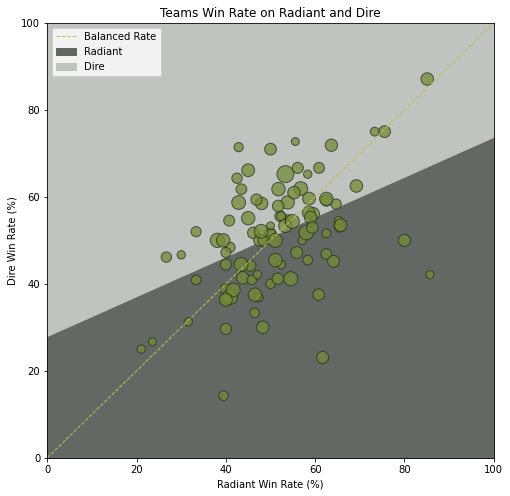

In [8]:
fig, ax = plt.subplots(figsize=(8,8))

plt.title("Teams Win Rate on Radiant and Dire")
ax.set_facecolor('#758b37')

ax.plot(np.linspace(0,100), np.linspace(0,100),
        c='#c1bd58',
        linewidth=1,
        linestyle='--',
        label='Balanced Rate')
ax.fill_between(np.linspace(0,100), curve_fit, color='#646864', label='Radiant')
ax.fill_between(np.linspace(0,100), 100, curve_fit, color='#c0c3c0', label='Dire')
ax.scatter(x=results['dire_win_rate']*100,
           y=results['radiant_win_rate']*100,
           s=results['matches']*2,
           c='#758b37',
           edgecolors='#292f1e',
           alpha=0.75)
ax.set_xbound(0,100)
ax.set_ybound(0,100)
ax.set_xlabel('Radiant Win Rate (%)')
ax.set_ylabel('Dire Win Rate (%)')

ax.legend()

In [31]:
results['heroes_played_per_match'] = results['unique_heroes_played']/results['matches']
results['heroes_banned_per_match'] = results['unique_heroes_banned_against']/results['matches']

heroes_played_per_match = results['heroes_played_per_match'].to_numpy()
heroes_banned_per_match = results['heroes_banned_per_match'].to_numpy()
wins = results['patch_wins'].to_numpy().reshape((-1,1))

lin_reg = LinearRegression()

poly_reg = PolynomialFeatures(degree=3)
wins_poly = poly_reg.fit_transform(wins)

lin_reg.fit(wins_poly, heroes_played_per_match)
curve_fit_played = lin_reg.predict(poly_reg.transform(np.linspace(0,100).reshape((-1,1))))

lin_reg.fit(wins_poly, heroes_banned_per_match)
curve_fit_banned = lin_reg.predict(poly_reg.transform(np.linspace(0,100).reshape((-1,1))))

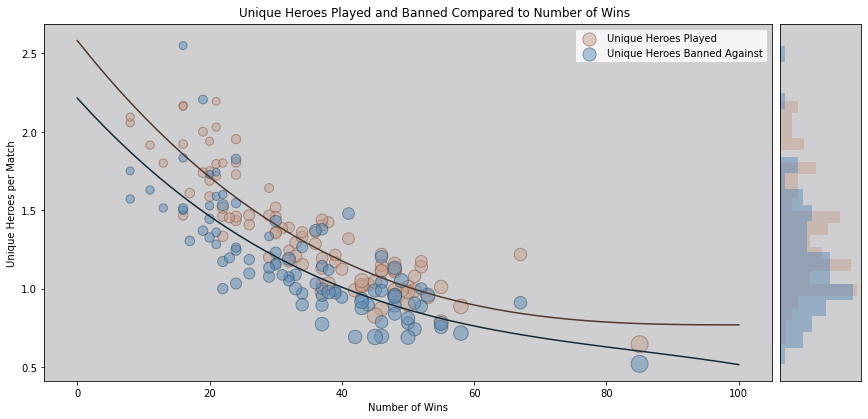

In [69]:
fig, (ax, ax_hist)= plt.subplots(1, 2, figsize=(12,6), sharey=True, gridspec_kw={'width_ratios': [9, 1]})

fig.suptitle("Unique Heroes Played and Banned Compared to Number of Wins")
ax.set_facecolor('#CFCFD2')

ax.scatter(x=results['patch_wins'],
           y=results['heroes_played_per_match'],
           s=results['matches']*2,
           c='#C5A191',
           edgecolors='#86513A',
           alpha=0.50,
           label='Unique Heroes Played')
ax.scatter(x=results['patch_wins'],
           y=results['heroes_banned_per_match'],
           s=results['matches']*2,
           c='#608CB7',
           edgecolors='#2B4A65',
           alpha=0.50,
           label='Unique Heroes Banned Against')
ax.plot(np.linspace(0,100), curve_fit_played, c='#4F382F')
ax.plot(np.linspace(0,100), curve_fit_banned, c='#142834')

ax.set_xlabel('Number of Wins')
ax.set_ylabel('Unique Heroes per Match')
ax.legend()

ax_hist.set_facecolor('#CFCFD2')
ax_hist.hist(results['heroes_played_per_match'], 
             bins=20, 
             density=True, 
             orientation='horizontal',
             alpha=0.5,
             color='#C5A191')
ax_hist.hist(results['heroes_banned_per_match'], 
             bins=20, 
             density=True, 
             orientation='horizontal',
             alpha=0.5,
             color='#608CB7',)
ax_hist.axes.xaxis.set_visible(False)
ax_hist.axes.yaxis.set_visible(False)
fig.tight_layout(rect=[0, 0.03, 1, 0.95], pad=0.5)